In [34]:
import torch
import numpy as np

from torch import nn

from torch.utils.data import DataLoader, TensorDataset

import torch.optim as optim

from einops import rearrange
from tqdm import tqdm

from dataclasses import dataclass
from generate_mass_spring_data import generate_mass_spring_data
from loss import compute_mmd

from matplotlib import pyplot as plt

from generate_3d_sho import generate_3d_sho

from sklearn.feature_selection import mutual_info_regression

In [35]:
@dataclass
class TrainConfig:
    num_epochs: int
    batch_size: int
    learning_rate: float
    device: str
    model: torch.nn.Module
    optimizer: optim.Optimizer 
    train_loader: DataLoader
    val_loader: DataLoader

In [39]:
def get_data_loaders(n_points: int, arr_size: int, batch_size: int = 32):
    # Set the seed for reproducibility
    torch.manual_seed(0)

    # Initialize an empty tensor to hold the samples
    samples = torch.zeros((arr_size, n_points, 3, 2))
    
    # Generate data samples
    for i in range(arr_size):
        low, high = 1, 10
        m, k = 1, torch.ones((3,1))
        v0, x0 = torch.randint(low, high, (2,3))
        samples[i] = rearrange(torch.stack(generate_3d_sho(k, m, v0, x0, 0.1, n_points)), 'c b d -> b d c')
    
    # Create a dataset from the samples tensor
    dataset = TensorDataset(samples)

    # Split dataset into training and validation datasets
    train_ds, val_ds = torch.utils.data.random_split(dataset, [int(0.8 * len(dataset)), int(0.2 * len(dataset))])

    # Calculate the mean and standard deviation for normalization
    train_mean = train_ds.dataset.tensors[0].mean()
    train_std = train_ds.dataset.tensors[0].std()

    # Normalize the training and validation datasets
    #for ds in (train_ds, val_ds):
    #    ds.dataset.tensors = ((ds.dataset.tensors[0] - train_mean) / train_std,)

    # Create dataloaders for the training and validation datasets
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False)
    
    return train_mean, train_std, samples, train_loader, val_loader

In [40]:
train_mean, train_std, samples, train_dl, val_dl = get_data_loaders(100, 1000)

In [51]:
def train(config: TrainConfig):
    
    model.to(config.device)
    
    losses = []
    conservation_losses = []
    reconstruction_losses = []
    pbar = tqdm(range(config.num_epochs))
    for epoch in pbar:
        ep_losses = []
        ep_conservation_losses = []
        ep_reconstruction_losses = []
        config.model.train()

        for i, data in enumerate(config.train_loader):
            orig_data = data[0].to(config.device)
            b = orig_data.shape[0]
            c = orig_data.shape[2] * 2
            formatted_data = rearrange(data[0], 'b s c d -> (b s) (c d)')
            data = formatted_data.to(config.device)
            encoder, decoder = config.model
            z = encoder(data)
            yhat = decoder(z)
            z_rearr = rearrange(z, '(b s) c -> b s c', b=b)
            z_0 = z_rearr[:, 0, :]
            # calculate the difference between z at each time step and z at time step 0
            z_diff = z_rearr - z_0[:, None, :]
            # calculate the conservation loss as mse
            conservation_loss = torch.mean(z_diff**2)
            
            #variance reconstruction loss
            yhat_std = rearrange(yhat, '(b s) (c d) -> b s c d', b=b, c=c)
            data_std = rearrange(orig_data.std(dim=1), 'b c d -> b 1 c d')
            data_mean = rearrange(orig_data.mean(dim=1), 'b c d -> b 1 c d')
            
            targets = torch.cat((data_mean, data_std), dim=2)
            #if i % 100 == 0:
            #    print(data_std[0], yhat_std[0])
            reconstruction_loss = torch.mean((yhat_std - targets)**2)
            #reconstruction_loss = torch.mean((yhat - orig_data)**2)

            loss = reconstruction_loss + 10 * conservation_loss
            config.optimizer.zero_grad()
            loss.backward(retain_graph=True)
            ep_losses.append(loss.clone().item())
            ep_conservation_losses.append(conservation_loss.clone().item())
            ep_reconstruction_losses.append(reconstruction_loss.clone().item())
            config.optimizer.step()
        config.model.eval()
        losses.append(np.mean(ep_losses))
        conservation_losses.append(np.mean(ep_conservation_losses))
        reconstruction_losses.append(np.mean(ep_reconstruction_losses))
        # update progress bar
        pbar.set_postfix({'loss': losses[-1], 'conservation_loss': conservation_losses[-1], 'reconstruction_loss': reconstruction_losses[-1]})
    return config.model, losses, conservation_losses, reconstruction_losses

In [52]:
for i, data in enumerate(train_dl):
    print(data[0].shape)
    break

torch.Size([32, 100, 3, 2])


In [53]:
def evaluate_model(model, data_loader, config):
    
    model = model.eval()
    model.to(config.device)
    losses = []
    conservation_losses = []
    reconstruction_losses = []
    
    for i, data in enumerate(data_loader):
        orig_data = data[0].to(config.device)
        b = orig_data.shape[0]
        c = orig_data.shape[2] * 2
        
        formatted_data = rearrange(data[0], 'b s c d -> (b s) (c d)')
        data = formatted_data.to(config.device)
        encoder, decoder = model
        
        z = encoder(data)
        yhat = decoder(z)
        z_rearr = rearrange(z, '(b s) c -> b s c', b=b)
        z_0 = z_rearr[:, 0, :]
        # calculate the difference between z at each time step and z at time step 0
        z_diff = z_rearr - z_0[:, None, :]
        # calculate the conservation loss as mse
        conservation_loss = torch.mean(z_diff**2)
        
        #variance reconstruction loss
        yhat_std = rearrange(yhat, '(b s) (c d) -> b s c d', b=b, c=c)
        data_mean = rearrange(orig_data.mean(dim=1), 'b c d -> b 1 c d')
        data_std = rearrange(orig_data.std(dim=1), 'b c d -> b 1 c d')
        targets = torch.cat((data_mean, data_std), dim=2)
     
        #if i % 100 == 0:
        #    print(data_std[0], yhat_std[0])
        reconstruction_loss = torch.mean((yhat_std - targets)**2)
        #reconstruction_loss = torch.mean((yhat - orig_data)**2)

        loss = reconstruction_loss + conservation_loss
        losses.append(loss.clone().item())
        conservation_losses.append(conservation_loss.clone().item())
        reconstruction_losses.append(reconstruction_loss.clone().item())
    return np.mean(losses), np.mean(conservation_losses), np.mean(reconstruction_losses)

## Dimension plots area

In [54]:
encoder = nn.Sequential(
    nn.Linear(6, 20),
    nn.Sigmoid(),
    nn.Linear(20, 12),
    nn.Sigmoid(),
    nn.Linear(12, 2)
)

decoder = nn.Sequential(
    nn.Linear(2, 6),
    nn.ReLU(),
    nn.Linear(6, 6),
    nn.ReLU(),
    nn.Linear(6, 12)
)

model = nn.Sequential(encoder, decoder)

_, _, _, train_loader, val_loader = get_data_loaders(1000, arr_size=100, batch_size=32)

config = TrainConfig(
    num_epochs=5000,
    batch_size=32,
    learning_rate=0.001,
    device='cuda',
    model=model,
    optimizer=optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5),
    train_loader=train_loader,
    val_loader=val_loader,
)

In [55]:
model, loss, conservation_loss, reconstruction_loss = train(config)

  0%|          | 0/5000 [00:00<?, ?it/s]


RuntimeError: The size of tensor a (1000) must match the size of tensor b (32) at non-singleton dimension 1

In [11]:
test_loss, test_conservation_loss, test_reconstruction_loss = evaluate_model(model, val_loader, config)

In [12]:
print(test_loss, test_conservation_loss, test_reconstruction_loss)

1.2483257055282593 0.00012288079597055912 1.2482028007507324


In [13]:
total_losses, conservation_losses, reconstruction_losses = [], [], []
for i in range(1,7):
    encoder = nn.Sequential(
        nn.Linear(6, 20),
        nn.Sigmoid(),
        nn.Linear(20, 12),
        nn.Sigmoid(),
        nn.Linear(12, i)
    )
    
    decoder = nn.Sequential(
        nn.Linear(i, 12),
        nn.ReLU(),
        nn.Linear(12, 12),
        nn.ReLU(),
        nn.Linear(12, 12)
    )
    model = nn.Sequential(encoder, decoder)
    config = TrainConfig(
        num_epochs=5000,
        batch_size=32,
        learning_rate=0.001,
        device='cuda',
        model=model,
        optimizer=optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5),
        train_loader=train_loader,
        val_loader=val_loader,
    )
    model, loss, conservation_loss, reconstruction_loss = train(config)
    test_loss, test_conservation_loss, test_reconstruction_loss = evaluate_model(model, val_loader, config)
    total_losses.append(test_loss)
    conservation_losses.append(test_conservation_loss)
    reconstruction_losses.append(test_reconstruction_loss)

100%|██████████| 5000/5000 [00:35<00:00, 140.71it/s, loss=0.521, conservation_loss=6.34e-5, reconstruction_loss=0.521] 


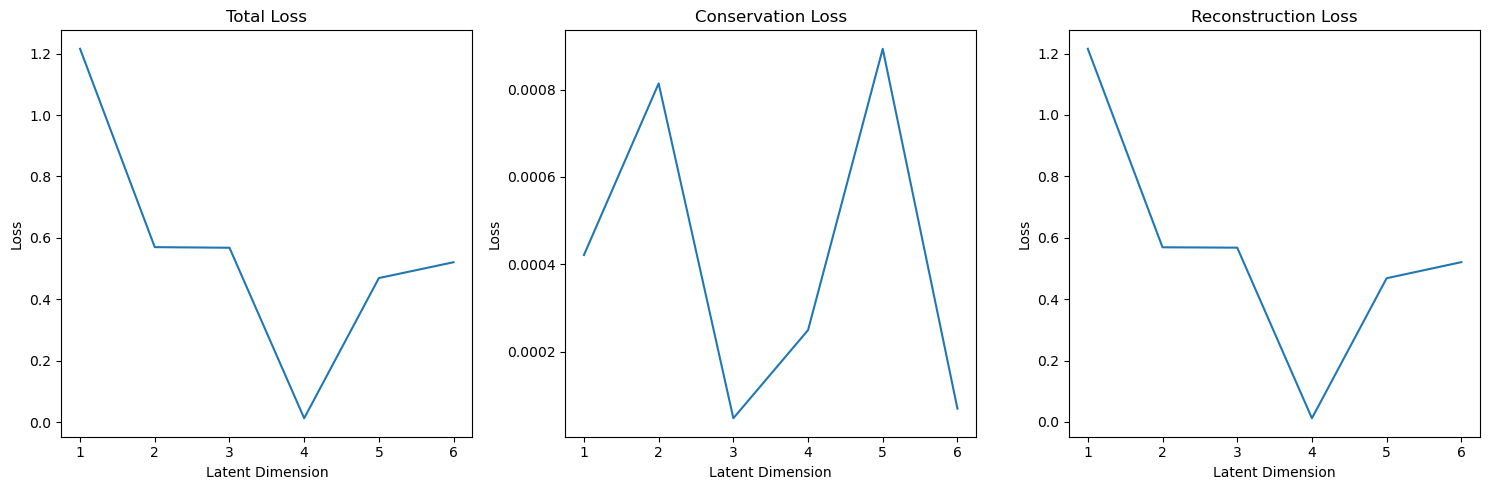

In [14]:
latent_dims = range(1,7)
fig, ax = plt.subplots(1,3, figsize=(15,5))
ax[0].plot(latent_dims, total_losses)
ax[0].set_title('Total Loss')
ax[1].plot(latent_dims, conservation_losses)
ax[1].set_title('Conservation Loss')
ax[2].plot(latent_dims, reconstruction_losses)
ax[2].set_title('Reconstruction Loss')
for a in ax:
    a.set_xlabel('Latent Dimension')
    a.set_ylabel('Loss')
plt.tight_layout()
plt.show()

model = model.eval()
x_test = torch.ones((1000,3))
y_test = torch.zeros((1000,3))
for i in range(1,10):
    for j in range(1,10):
        for k in range(1,10):
            y_test[i+j+k] = torch.tensor([i,j,k])
test = rearrange(torch.stack((x_test, y_test)), 'c b a -> b (c a)').to(config.device)
zs = model[0](test).cpu()
energy = 0.5 * torch.sum(y_test**2, dim=1) + 0.5 * torch.sum(x_test**2, dim=1)
fig, ax = plt.subplots(2,2, figsize=(10,10))
ax[0,0].scatter(energy, zs[:,0].detach().numpy(), label='z1')
ax[0,1].scatter(energy, zs[:,1].detach().numpy(), label='z2')
#ax[1,0].scatter(energy, zs[:,2].detach().numpy(), label='z3')
#ax[1,1].scatter(energy, zs[:,3].detach().numpy(), label='z4')
plt.show()




In [12]:
import scipy.constants as const

In [13]:
(8 * np.pi **  6 * (4.803e-10) ** 4 * 9.11e-28) / ((1.0546e-27) ** 2)

3.3526051877402376e-07

## Conserved Quantities Check

In [28]:
encoder = nn.Sequential(
    nn.Linear(6, 20),
    nn.Sigmoid(),
    nn.Linear(20, 12),
    nn.Sigmoid(),
    nn.Linear(12, 4)
)

decoder = nn.Sequential(
    nn.Linear(4, 12),
    nn.ReLU(),
    nn.Linear(12, 12),
    nn.ReLU(),
    nn.Linear(12, 12)
)

model = nn.Sequential(encoder, decoder)

train_mean, train_std, samples, train_loader, val_loader = get_data_loaders(1000, arr_size=100, batch_size=32)

config = TrainConfig(
    num_epochs=50000,
    batch_size=32,
    learning_rate=0.001,
    device='cuda',
    model=model,
    optimizer=optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5),
    train_loader=train_loader,
    val_loader=val_loader,
)
model, loss, conservation_loss, reconstruction_loss = train(config)

100%|██████████| 50000/50000 [06:33<00:00, 127.22it/s, loss=0.00761, conservation_loss=4.31e-5, reconstruction_loss=0.00718] 


In [30]:
#Evaluate Mutual Info in 3-D Case
model = model.eval()
x_test = torch.ones((1000,3))
y_test = torch.zeros((1000,3))
for i in range(1,10):
    for j in range(1,10):
        for k in range(1,10):
            y_test[i+j+k] = torch.tensor([i,j,k])
test = rearrange(torch.stack((x_test, y_test)), 'c b a -> b (c a)').to(config.device)
zs = model[0](test).cpu()
energy = 0.5 * torch.sum(y_test**2, dim=1) + 0.5 * torch.sum(x_test**2, dim=1)
mutual_info_regression(zs.detach().numpy(),energy.detach().numpy(), discrete_features=False)

array([0.1103913 , 0.14803573, 0.13658284, 0.11274422])

In [31]:
from threed_sho_conserved_qts import energy_angular_momentum

# Prepare data
data = samples.to(config.device).detach().clone()
data = rearrange(data, 'b s c d -> (b s) (c d)')

# Calculate ground truth energy and angular momentum
gnd_truth_energy, gnd_truth_ang_mom = energy_angular_momentum(data[:,:3], data[:,3:], 1, 1)

# Use the model to predict 'z_samples'
model.eval()
z_samples = model[0](data).detach().clone()

# Combine ground truth values into one tensor
targets = torch.cat((gnd_truth_energy, gnd_truth_ang_mom), dim=1)

# Create a dataset from the model's predictions and the targets
z_dataset = TensorDataset(z_samples, targets)

# Split dataset into training and validation datasets
z_train_ds, z_val_ds = torch.utils.data.random_split(z_dataset, [int(0.08*len(z_dataset)), int(0.92*len(z_dataset))])

# Normalize the z_samples
train_z_mean = z_train_ds.dataset[:][0].mean()
train_z_std = z_train_ds.dataset[:][0].std()

# Normalize the targets
train_targets_mean = z_train_ds.dataset[:][1].mean()
train_targets_std = z_train_ds.dataset[:][1].std()

# Create data loaders for the normalized training and validation datasets
z_train_dl = DataLoader(z_train_ds, batch_size=32, shuffle=True)
z_val_dl = DataLoader(z_val_ds, batch_size=32, shuffle=False)

In [32]:
conserved_model = nn.Sequential(
    nn.Linear(4, 12),
    nn.ReLU(),
    nn.Linear(12, 40),
    nn.ReLU(), 
    nn.Linear(40, 40),
    nn.ReLU(),
    nn.Linear(40, 12),
    nn.ReLU(),
    nn.Linear(12, 4)
)

conserved_model.to(config.device)

Sequential(
  (0): Linear(in_features=4, out_features=12, bias=True)
  (1): ReLU()
  (2): Linear(in_features=12, out_features=40, bias=True)
  (3): ReLU()
  (4): Linear(in_features=40, out_features=40, bias=True)
  (5): ReLU()
  (6): Linear(in_features=40, out_features=12, bias=True)
  (7): ReLU()
  (8): Linear(in_features=12, out_features=4, bias=True)
)

In [56]:
#training loop
conserved_model.train()
conserved_optimizer = optim.Adam(conserved_model.parameters(), lr=0.01)
conserved_losses = []
conserved_val_losses = []
pbar = tqdm(range(10000))
for epoch in pbar:
    ep_losses = []
    for i, data in enumerate(z_train_dl):
        x, y = data
        x = (x - train_z_mean) / train_z_std
        y = (y - train_targets_mean) / train_targets_std
        y_hat = conserved_model(random)
        loss = torch.mean((y_hat - y)**2)
        conserved_optimizer.zero_grad()
        loss.backward()
        conserved_optimizer.step()
        ep_losses.append(loss.clone().item())
    conserved_losses.append(np.mean(ep_losses))
    
    if epoch % 10 == 0:
        conserved_model.eval()
        val_losses = []
        for i, data in enumerate(z_val_dl):
            x, y = data
            x = (x - train_z_mean) / train_z_std
            y = (y - train_targets_mean) / train_targets_std
            y_hat = conserved_model(x)
            loss = torch.mean((y_hat - y)**2)
            val_losses.append(loss.clone().item())
        conserved_val_losses.append(np.mean(val_losses))
    pbar.set_postfix({'loss': conserved_losses[-1], 'val_loss': conserved_val_losses[-1]})


  1%|          | 80/10000 [00:37<1:17:26,  2.13it/s, loss=0.455, val_loss=0.456]


KeyboardInterrupt: 

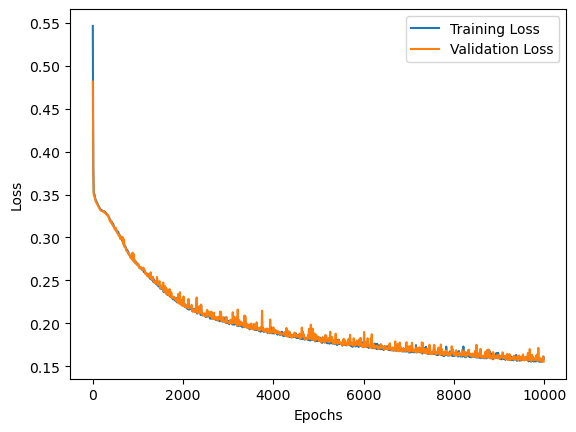

In [60]:
epochs = range(0, 10000, 10)
plt.plot(epochs, conserved_losses[::10], label='Training Loss')
plt.plot(epochs, conserved_val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [58]:
len(conserved_losses[::10])

1000